In [1]:
#Begin by importing the libraries that will be needed for training
import cv2
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import os 
import random as rand
import gc




In [2]:
#The code below outlines reading image files into memory
train_dir = '../input/dogs-vs-cats-redux-kernels-edition/train'
test_dir = '../input/dogs-vs-cats-redux-kernels-edition/test'
train_dogs = [train_dir+'/{}'.format(i) for i in os.listdir(train_dir) if 'dog' in i]  #get dog images
train_cats = [train_dir+'/{}'.format(i) for i in os.listdir(train_dir) if 'cat' in i]  #get cat images

test_imgs = ['../input/test/{}'.format(i) for i in os.listdir(test_dir)] #get test images

train_imgs = train_dogs[:2000] + train_cats[:2000]  # slice the dataset and use 2000 in each class
rand.shuffle(train_imgs)  # shuffle it randomly

#Clear lists that are useless now to save memory
del train_dogs
del train_cats
gc.collect()   

19

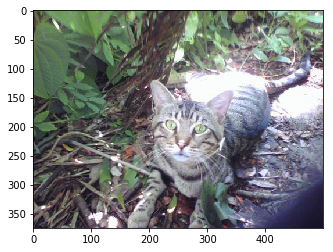

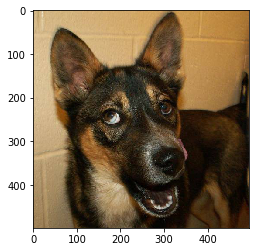

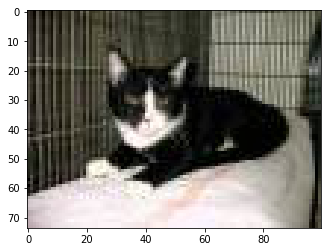

In [3]:
#To assure that files have been transferred properly, view the first 3 shuffled images
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img=mpimg.imread(ima)
    imgplot=plt.imshow(img)
    plt.show()

In [4]:
#Declaring image dimensions-notice that the images that were viewed in the previous block had different dimensions
nrows=150
ncolumns=150
channels=3

In [5]:
#This function iterates through the images, resizes them , and then appends them to the X and y list
#The X list will hold the training data set, and the y list will hold the training labels (1=dog, 0=cat)
def read_and_process_image(list_of_images):
    X= []
    y= []
    for image in train_imgs:
        X.append(cv2.resize(cv2.cvtColor(cv2.imread(image, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))
        if 'dog.' in image:
            y.append(1)
        elif 'cat.' in image:
            y.append(0)
    return X, y







In [6]:
X, y = read_and_process_image(train_imgs)

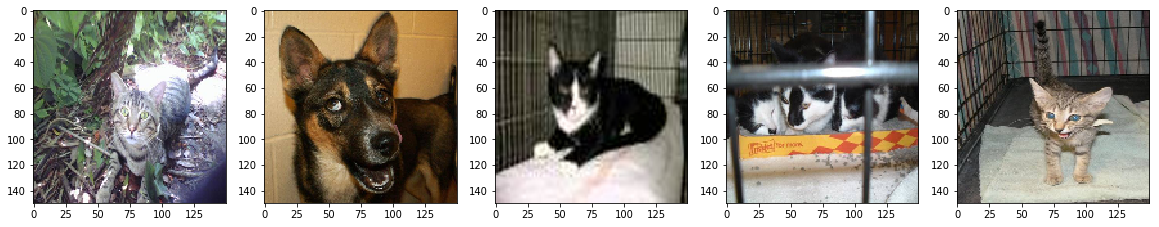

In [7]:
#Before moving forward, check that the training set is appropriate and standardized
plt.figure(figsize=(20,10))
columns=5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(X[i])

Text(0.5, 1.0, 'Labels for Cats and Dogs')

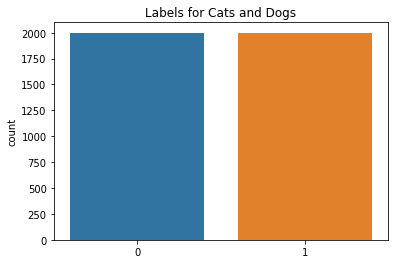

In [8]:
#Seaborn is a plotting package. This provides an easy to read graph for the make-up of the training set.
import seaborn as sns #plots data
# del train_imgs
gc.collect()

#list to numpy array
X= np.array(X)
y= np.array(y)

sns.countplot(y)
plt.title ('Labels for Cats and Dogs')



In [9]:
#Checking shapes- should be 4 dimensional array with dimensions 4000 x 150 x 150 x 3 which correspond to the batch size, height, width and channel
#The shape of the data is important for using the Keras model for machine learning, which takes input in the array of (height, width, channels)
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train images is: (4000, 150, 150, 3)
Shape of labels is: (4000,)


In [10]:
#Before beginning training, it is important to split data into a train and validation set. This is done here using a package called sklearn. 20% of the data is assigned for the validation set and the other 80% to the training set.
#For reference:
#Training Set- this data set is used to adjust the weights on the neural network.
#Validation Set-this data set is used to minimize overfitting;verifying that any increase in accuracy over the training data set actually yields an increase in accuracy over a data set that has not been shown to the network before, or at least the network hasn't trained on it 
#Testing Set- this data set is used only for testing the final solution in order to confirm the actual predictive power of the network.
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

print('Shape of Train images is:', X_train.shape)
print('Shape of validation images is', X_val.shape)
print('Shape of labels is:', y_train.shape)
print('Shape of labels is:', y_val.shape)

Shape of Train images is: (3200, 150, 150, 3)
Shape of validation images is (800, 150, 150, 3)
Shape of labels is: (3200,)
Shape of labels is: (800,)


In [11]:
#Finding length of the train and validation set
ntrain = len(X_train)
nval = len(X_val)

batch_size=32

In [12]:
#Creating the Convolutional Neural Network(CNN) model- 
#1.Begin by importing keras modules
#2.Create the network architecture (the way convolution layers are arranged) using the VGGnet structure.
from keras import layers
from keras import models 
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3),activation=('relu'), input_shape=(150, 150,3)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation= 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(5,5), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))


Using TensorFlow backend.


In [13]:
#Preview the arrangement and parameter size of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)      

In [14]:

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=2e-5), metrics=['acc'])

In [15]:
#The code below is to assure that augmented images in the test set will be recognized
train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255) 

In [16]:
#Create the image generators
train_generator= train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator= val_datagen.flow(X_val, y_val,batch_size=batch_size)


In [17]:
#The Training- trained for 64 epochs with about 100 steps per epoch
history=model.fit_generator(train_generator,
                           steps_per_epoch=ntrain//batch_size,
                           epochs=64,
                           validation_data=val_generator,
                           validation_steps=nval//batch_size)

Epoch 1/64
100/100 [==============================] - 20s 202ms/step - loss: 0.9650 - acc: 0.5647 - val_loss: 0.7020 - val_acc: 0.5337
Epoch 2/64
100/100 [==============================] - 15s 153ms/step - loss: 0.8940 - acc: 0.5750 - val_loss: 0.7580 - val_acc: 0.5312
Epoch 3/64
100/100 [==============================] - 16s 158ms/step - loss: 0.9130 - acc: 0.5647 - val_loss: 0.6574 - val_acc: 0.5500
Epoch 4/64
100/100 [==============================] - 16s 156ms/step - loss: 0.8168 - acc: 0.5984 - val_loss: 0.6730 - val_acc: 0.6237
Epoch 5/64
100/100 [==============================] - 16s 155ms/step - loss: 0.7953 - acc: 0.6137 - val_loss: 0.5381 - val_acc: 0.6500
Epoch 6/64
100/100 [==============================] - 15s 155ms/step - loss: 0.7595 - acc: 0.6194 - val_loss: 0.5439 - val_acc: 0.6575
Epoch 7/64
100/100 [==============================] - 16s 156ms/step - loss: 0.7336 - acc: 0.6372 - val_loss: 0.5092 - val_acc: 0.6888
Epoch 8/64
100/100 [==============================] - 1

In [18]:
#Save the model to re-use it anytime without having to rerun the notebook
model.save_weights('model_wieghts.h5')
model.save('model_keras.h5')


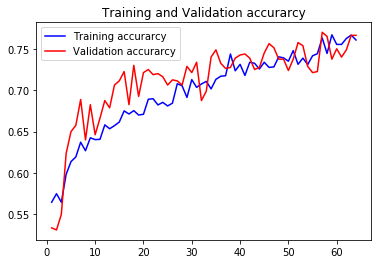

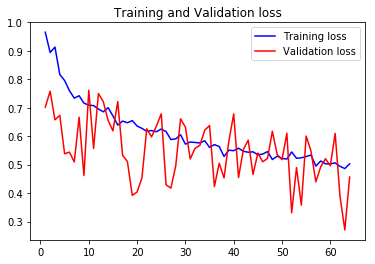

In [19]:
#Plotting graphs of accuracy and loss of the train and validation set to provide further insight to the accuracy of the model.
import matplotlib.pyplot as plt

#get the details from the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [20]:
#Function to smooth our graph for easier analysis
def smooth_plot(points, factor=0.7):
    smooth_pts = []
    for point in points:
        if smooth_pts:
            previous = smooth_pts[-1]
            smooth_pts.append(previous * factor + point * (1 - factor))
        else:
            smooth_pts.append(point)
    return smooth_pts

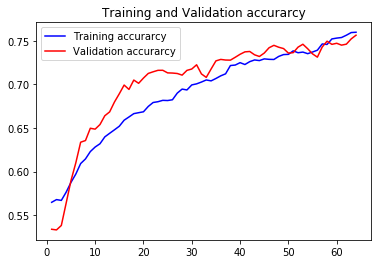

In [21]:
#Plot figure
plt.plot(epochs, smooth_plot(acc), 'b', label='Training accurarcy')
plt.plot(epochs, smooth_plot(val_acc), 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.show()